# imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Ensemble Learning and Random Forests

Suppose you ask a complex question to thousands of random people, the aggregate their answers. You'll often find that this answer is better than an expert's answer. This is known as the *wisdom of the crowd*. In ML, aggregating the predictions of a group of predictors will often yield better predictions than with the best individual predictor. A group of predictors is known as an *ensemble*; thus, this technique is known as *Ensemble Learning*. (An ensemble learning algo is known as an *Ensemble method*).

An example is training a group of Decision Trees, each on a different subset of the training set. To make predictions, you just obtain the predictions of all of the individual trees, then predict the class that gets the most votes (see the last exercise of the previous chapter for an example). Such an ensemble of Decision Trees is known as a *Random Forest*, and despite the simplicity, is one of the most powerful ML algos available today.

Moreover, as discussed in chapter 2, Ensemble methods are often used near the en of a project once a few good predictors have been built to combine them into an even better one.

In this section, we'll cover some of the popular Ensemble methods (such as *bagging*, *boosting*, *stacking*, and some others) as well as Random Forests

## Voting Classifiers

Let's say you've trained a few classifiers, each reaching about 80% accuracy. You may have a Logistic Regression, SVM, Random Forest, K-Nearest Neighbors, and maybe some more. A simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a *hard voting* classifier.

Surprisingly, this classifier often achieves higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a *weak learner* (it does only slightly better than random guessing), the ensemble can still be a *strong learner* (achieving high accuracy) provided there are sufficient number of weak learners and they are sufficiently diverse. This is possible because of the *law of large numbers*.

*Note: ensemble methods work best when the predictors are as independent from one another as possible. One way to get this is to train the classifiers using very different algos. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.*

The following code creates and trains a voting classifier in sklearn, composed of three diverse classifiers. We'll use the moons dataset for this

In [2]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Grab and separate the data
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The VotingClassifier is just slightly worse than the SVC in our case! If all classifiers have the `predict_proba()` method implemented, then you can tell sklearn to predict the class with the highest class probability, averaged over all the individual classifiers. This is known as *soft voting*. It often does better than hard voting because it gives more weight to highly confident votes. To do this, all we need to do is replace the `voting='hard'` with `voting='soft'` in the parameter list and ensure that all classifiers used have that method implemented. This is not the case of `SVC` by default, so the `probability` hyperparameter needs to be set to `True` (which makes the `SVC` class do cross-validation to estimate probabilities, slowing down training, and it will add a `predict_proba()` method). Let's do that now and check the accuracy

In [4]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.912

## Bagging and Pasting

Another approach for getting a diverse set of classifiers is to use the same training algo for each predictor, but to train them on different random subsets of the training set. When done *with* replacement, this is known as [bagging](https://goo.gl/o42tml) which is short for *bootstrap aggregating*. When sampling is performed *without* replacement, it is called [pasting](https://goo.gl/BXm0pm).

In other words, both methods allow training instances to be sampled several times across multiple predictors, but only bagging allows training instance to be sampled several time for the same predictor.

Once all predictors are trained, the ensemble can make a new prediction for an incoming instance by aggregating the predictions of the predictors. The aggregation function is typically the *statistical mode* for classification, or the *statistical mean/average* for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregating reduces both bias and variance. Generally the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

These methods are popular because they can be used to train in parallel on different threads/CPU cores/servers. Predictions can also be made in parallel, making these methods highly scalable.

## Bagging and Pasting in Scikit-Learn

Sklearn has a simple set of classes for both bagging and pasting using the `BaggingClassifier` class (or `BaggingRegressor`). The following code trains an ensemble of 500 Decision Trees each trained on 100 training instances randomly sampled with replacement (so we're using bagging here). If you want pasting, use `bootstrap=False`. The `n_jobs` param tells sklearn how many cores to use for training and prediction (-1 means "use all available"):

*Note: the `BaggingClassifer` automatically performs soft voting if the base classifier can estimate class probabilities (has a `predict_proba` method).*

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500,
                           max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Bootstrapping adds a bit more diversity into the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting (but this also means that predictors end up being less correlated so the ensemble's variance is reduced). Overall, bagging often results in better models, which explains why it is (generally) preferred. However, if you have spair time and CPU power you can cross-validate to evaluate both bagging and pasting and select the better one.

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor whilst others may not be sampled at all. By default, a `BaggingClassifier` samples $m$ training instances with replacement (`bootstrap=True`) where $m$ is the size of the training set. This means that only ~63% of the training instances are sampled on average for each predictor. The rest that aren't sampled are called *out-of-bag* (oob) instances.

Since a predictor never sees these instances during training, it can be evaluated on them wihtout the need for separate validation set/cross validation. You can evaluate the ensemble itself by averaging out the oob predictions of each predictor.

Sklearn has the option to set `oob_score=True` when creating a `BaggingClassifier` to request automatic oob evaluation after training. Here's an example:

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [7]:
# Our evaluations predicts us getting 90.1% accuracy on the test set. Let's check that
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

91% accuracy, not bad!

The decision function for each training instance is available through the `oob_decision_function_` variable. In this case, (since the base estimator has a `predict_proba()` method) the decision function returns the class probabilities for each training instances.

In [8]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

## Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features also. This is controlled by the `max_features` and `bootstrap_features` hyperparameters. They work the same way that `max_samples` and `bootstrap` do, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This is useful when dealing with high-dimensional inputs (like photos). Sampling both training instances and features is called [*Random Patches*](https://goo.gl/B2EcM2). Keeping all training instances (`boostrap=False` and `max_samples=1.0`) but sampling instances (`bootstrap_features=True` and/or `max_features < 1.0`) is called the [*Random Subspaces method*](https://goo.gl/NPi5vH).

*Note: sampling features results in even more predictor diversity, trading a bit more bias for a lower variance*.

## Random Forests

A Random Forest is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class instead (there's a similar `RandomForestRegressor` as well. The following code will train a random forest with 500 treas (each limited to 16 nodes) using all available CPU cores:

In [9]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.92

With a few exceptions, the hyperparameters for `RandomForestClassifier` and `DecisionTreeClassifier` the same, plus the inclusion of all of the `BaggingClassifier` hyperparameters.

The algo introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best features among a random subset of features. This will result in greater tree diversity- which once again trades higher bias for lower variance and it will (generally) yield an overall better model. The following `BaggingClassifier` is *roughly* equivalent to the `RandomForestClassifier` from earlier:

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred_bg = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_bg)

0.904

## Extra-Trees

When a tree in the Random Forest is growing, at each node we have a random subset of the features that gets considered for splitting. It's possible to make these trees more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely-random trees is known as an [*Extremely Randomized Tree*](https://goo.glRHGEA4). Once again, this trades more bias for lower variance. It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time consuming tasks of growing a decision tree.

Sklearn has a class called `ExtraTreesClassifier`, with an identical API to the `RandomForestClassifier` class. Similarly, the `RandomForestRegressor` has the same API as the `RandomForestRegressor`.

Generally, it's hard to know which will perform better so the only way to know is to try both and compare using cross-validation.

## Feature Importance

Another great quality of RandomForests is that they make it easy to measure relative importance of each feature. Sklearn measures a feature's importance by looing how much the tree nodes that use the feature reduce impurity on average (across all trees in the forest). More accurately, it's a weighted average where each node's weight is equal to the number of training samples that are associated with it.

Sklearn does this automatically for each feature after training, then scoes the results so that the sum of all importances is equal to 1. You can access this result using `feature_importances_variable`. For example, the next bit will train a RandomForestClassifier on the iris dataset and outputs each feature's importance.

Overall, Random Forests are extremely handy to get a quick understanding of what features actually matter (especially if you need to do feature selection).

In [11]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


## Boosting

*Boosting* (originally called *hypothesis boosting* refers to any Ensemble method that can combine serveral weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many methods available, but the most popular by far are [*AdaBoost*](https://goo.gl/OIduRW) (short for *Adaptive Boosting*) and *Gradient Boosting*. Firstly, AdaBoost.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is, in essence, the magic behind AdaBoost.

To build an AdaBoost classifier, a first base classifier (like a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

This sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor's parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

*Note: There's one important drawback to this technique; it cannot be parallelized (or only partially) since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it doesn't scale as well as bagging or pasting do.*

Time to take a closer look at the algorithm. Each instance weight $w^i$ is initially set to $\frac{1}{m}$. A first predictor is trained and its weighted error rate $r_1$ is computed on the training set. Here's the equation for this section:

$$r_j = \frac{\mathop{\sum_{i=1}^m w^i}_{\hat{y}_j^i \neq y^i}}{\sum_{i=1}^m w^i} \text{ where $\hat{y}_j^i$ is the $j^{th}$ predictor's prediction for the $i_{th}$ instance}.$$

The predictor's weight $\alpha_j$ is then computed using the next equation, where $\eta$ is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the heigher its weight will be. If it's just randomly guessing, then its weight will be close to 0. However, if it's most often wrong (i.e., less accurate then random guessing) then its weight will be negative:

$$\alpha_j = \eta\log\frac{1 - r_j}{r_j}$$

Next up, the instance weights are updated using the next equation; the misclassified instances are boosted.

$$\text{for } i = 1, 2, \cdots, m\\ w^i \leftarrow \begin{align*}\left\{\begin{array}{ll}w^i &\text{if $\hat{y}_j^i = y^i$} \\ w^i\exp(\alpha_j) &\text{if $\hat{y}_j^i \neq y^i$}\end{array}\right.\end{align*}$$

Then, all the instances wates are normalized (so they're divided by $\sum_{i=1}^m w^i$).

Finally, a new predictor is trained using the updated weights and the whole process is repeated. The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

For prediction making, AdaBoost simply computes the prodictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes. Here's the equation:

$$\hat{y}(\textbf{x}) = \mathop{\text{argmax}}_k \mathop{\sum_{j=1}^N}_{\hat{y}_j(\textbf{x}) = k} \alpha_j \text{ where $N$ is the number of predictors.}$$

Sklearn uses as multiclass version of AdaBoost called [*SAMME*](https://goo.gl/Eji2vR) (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), sklearn cause use a varient of SAMME called *SAMME.R* (the *R* stands for "Real") which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 *Decision Stumps* using sklearn's `AdaBoostClassifier` class (and there's an `AdaBoostRegressor` as well). A Decision Stump is a Decision Tree with `max_depth=1` (so a tree composed of a single decision node + two leaf nodes):

*Note: if your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator*

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

### Gradient Boosting

Another popular boosting algorithm is [*Gradient Boosting*](https://goo.gl/Ezw4jL). Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correccting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the *residual errors* made by the previous predictor.

Let's go through a simple regression example using Decision Trees as the base predictors. This is called *Gradient Tree Boosting* or *Gradient Boosted Regression Trees* (*GBRT*). First, let's fit a `DecisionTreeRegressor` to the training set (for example, a noisy quadratic training set):

In [13]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now we train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [14]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Do it again, but on the residual errors made by the second predictor:

In [15]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Now our 3 tree ensemble can make predictions on a new instance  by summing the predictions of all of the trees:

In [16]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

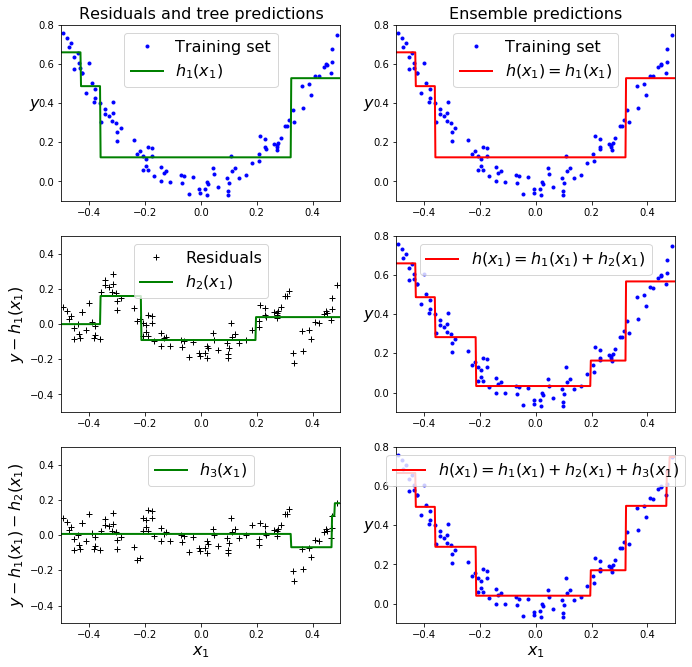

In [17]:
# Here are some nice graphs to see visuals of what we've done
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

A simpler way to train GBRT ensembles is to use sklearn's `GradientBoostingRegressor` class. Much like the `RandomForestRegressor`, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`, and so on) as well as hyperparams to control the ensemble training, such as the number of trees (`n_estimators`). The `learning_rate` hyperparam scales the contribution of each tree. If set to a low value (such as 0.1), more trees in the ensemble will be needed to fit the training set (but the predictions will usually generalize better). This is a regularization technique known as *shrinkage*. The following code creates the same ensemble as the previous one

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In order to find the optimal number of trees, you can use early stopping (from Chapter 4). A simple way to implement this is to used the `staged_predict()` method; it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, then finally trains another GBRT ensemble using the optimal number of trees:

In [19]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

y_pred = gbrt_best.predict(X_val)

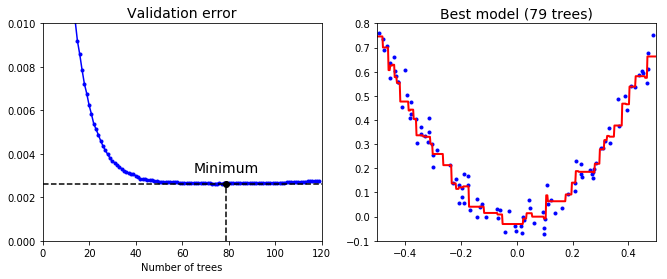

In [20]:
# Nice little graph for the visual learners

min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.show()

It's also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). This can be done by setting `warm_start=True` which makes sklearn keep existing trees when the `fit()` method is called, allowing incremental training. The following code stops training when the validation error doesn't improve for five iterations in a row:

In [21]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            print('Stopping...')
            break

Stopping...


In [22]:
print(gbrt.n_estimators)

59


In [23]:
print("Minimum validation MSE: {}".format(min_val_error))

Minimum validation MSE: 0.0026930464329994377


The `GradientBoostingRegressor` class also supports a `subsample` hyperparam, which specifies the fraction of training instances to be used for training each tree. For example, if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is known as *Stochastic Gradient Boosting*.

*Note: it's possible to use Gradient Boosting with other cost functions. This is controlled by the `loss` hyperparameter. See the documentation for more details.*

## Stacking

The last ensemble method for this chapter is known as [*stacking*](https://goo.gl/9I2NBw) (short for *stacked generalization*). It's based on a simple idea; instead of using trivial functions (like hard voting) to aggregate the predictions of all predictions in an ensemble, why don't we just train a model to do this aggregation? For this, a final predictor (known as a *blender* or *meta learner*) takes the predictions from the input models and makes a final predictor.

For blender training, a common approach is to use a hold-out set (though out-of-fold pedictions is also possible). First, the training set is split into two subsets. The first subset is used to train the predictors in the first layer. Next, the first layer predictors are used to make predictions on the second (held-out) set. Now for each instance in the hold-out set, there are three predicted valuse that can be used to create a new training set. The blender is trained on this new set, so it learns to predict the target value given the first layer's predictions.

It's possible to train several different blenders this way (e.g., one using Linear Regression, one using Random Forest Regression, and so on); we get a whole layer of blenders. The trick is to split the training set into three subsets. The first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer) and the third is used to create the training set to train the third layer (using the predictions made by the predictors of the second layer). Once this is done, we can make a prediction fot a new instance by going through each layer sequentially.

This kind of sounds like a neural network, and in a way it kind of is.

Sadly, sklearn doesn't stupport stacking directly, but it's not that bad to implement (as we'll see shortly).

# 8) Voting Classifier

In [25]:
%%time

from sklearn.datasets import fetch_mldata

home = expanduser("~/Coding Stuff/Python/handson-ml/datasets/")

# If we have the data, remove it first
find_and_remove('mnist-original.mat')

# Download the data
mnist = fetch_mldata("MNIST original", target_name='target', data_home=home)

# split our data

# Split into test data and train/validation data
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)

# Now split into train data and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

CPU times: user 1.76 s, sys: 2.38 s, total: 4.13 s
Wall time: 29.9 s


In [26]:
# Create classifiers
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# First up, RandomForest
random_forest_clf = RandomForestClassifier(random_state=42)

# Next, ExtraTrees
extra_trees_clf = ExtraTreesClassifier(random_state=42)

# Support Vector Machine
svm_clf = LinearSVC(random_state=42)

# Last, a neural network (!!)
mlp_clf = MLPClassifier(random_state=42)

# populate a list of our classifiers
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

In [27]:
# Train classifiers (could take a while)
for estimator in estimators:
    print("Training the {}".format(estimator))
    estimator.fit(X_train, y_train)
    
# Get scores from validation set
[estimator.score(X_val, y_val) for estimator in estimators]

Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr',

[0.9467, 0.9512, 0.8547, 0.9542]

LinearSVM gets pretty wrecked by the other classifiers... for now. But we'll keep it around for the voting classifier

In [28]:
named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf)
]

voting_clf = VotingClassifier(named_estimators)

In [31]:
# Train our VotingClassifier (again may take a while because of SVM)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [32]:
# Get scores from validation set
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9467, 0.9512, 0.8547, 0.9542]

In [33]:
# Let's remove the SVM and see if it's better
voting_clf.set_params(svm_clf=None)

# This updated the list of estimators
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       

In [34]:
# But the list of TRAINED estimators is the same
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_

In [35]:
# We can either retrain, or just delete the SVM

del voting_clf.estimators_[2]

# Re-evaluate the voting classifier
voting_clf.score(X_val, y_val)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9654

In [36]:
# Better! The SVM was messing things up. Now, we'll use a soft voting classifier
# retraining isn't necessary since we can change the voting hyperparameter to 'soft'

voting_clf.voting = 'soft'

voting_clf.score(X_val, y_val)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9683

In [37]:
# So far, this one is the best one. Let's check it against the test set and each classifier on the test set
voting_clf.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.965

In [38]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9434, 0.9444, 0.9524]

The voting classifier reduced the error rate from about 4.9% for our best model (the `MLPClassifier`) to just 3.5%. That's about 28% less errors, not bad!

# 9) DIY Stacking Ensemble

In [39]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [40]:
X_val_predictions

array([[2., 2., 2., 2.],
       [7., 7., 7., 7.],
       [4., 4., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [9., 9., 9., 9.],
       [4., 4., 4., 4.]], dtype=float32)

In [41]:
# Create a RandomForest blender and train it on the predictions

rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [42]:
rnd_forest_blender.oob_score_

0.9613

Let's try other kinds of blenders. Perhaps a neural network blender?

In [43]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [44]:
mlp_blender = MLPClassifier(random_state=42)
mlp_blender.fit(X_val_predictions, y_val)

y_pred = mlp_blender.predict(X_val_predictions)
accuracy_score(y_val, y_pred)

0.9583

So our Neural Network blender is actually worse than the RandomForestClassifier. We'll rock with the RandomForest one for now then. How bout some Grid Search for finding the best hyperparameters?

In [47]:
from sklearn.model_selection import GridSearchCV

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
param_grid = [
    {'n_estimators': list(range(1, 101)), 'max_depth': list(range(1, 5))},
]
best_blender = GridSearchCV(rnd_forest_blender, param_grid, cv=3, verbose=2)
best_blender.fit(X_val_predictions, y_val)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=1 .....................................
[CV] ...................... max_depth=1, n_estimators=1, total=   0.0s
[CV] max_depth=1, n_estimators=2 .....................................
[CV] ...................... max_depth=1, n_estimators=2, total=   0.0s
[CV] max_depth=1, n_estimators=2 .....................................
[CV] ...................... max_depth=1, n_estimators=2, total=   0.0s
[CV] max_depth=1, n_estimators=2 .....................................
[CV] ...................... max_depth=1, n_estimators=2, total=   0.0s
[CV] max_depth=1, n_estimators=3 .....................................
[CV] ........

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserW

[CV] ...................... max_depth=1, n_estimators=6, total=   0.0s
[CV] max_depth=1, n_estimators=6 .....................................
[CV] ...................... max_depth=1, n_estimators=6, total=   0.0s
[CV] max_depth=1, n_estimators=6 .....................................
[CV] ...................... max_depth=1, n_estimators=6, total=   0.0s
[CV] max_depth=1, n_estimators=7 .....................................
[CV] ...................... max_depth=1, n_estimators=7, total=   0.0s
[CV] max_depth=1, n_estimators=7 .....................................
[CV] ...................... max_depth=1, n_estimators=7, total=   0.0s
[CV] max_depth=1, n_estimators=7 .....................................
[CV] ...................... max_depth=1, n_estimators=7, total=   0.0s
[CV] max_depth=1, n_estimators=8 .....................................
[CV] ...................... max_depth=1, n_estimators=8, total=   0.0s
[CV] max_depth=1, n_estimators=8 .....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=1, n_estimators=8, total=   0.0s
[CV] max_depth=1, n_estimators=8 .....................................
[CV] ...................... max_depth=1, n_estimators=8, total=   0.0s
[CV] max_depth=1, n_estimators=9 .....................................
[CV] ...................... max_depth=1, n_estimators=9, total=   0.0s
[CV] max_depth=1, n_estimators=9 .....................................
[CV] ...................... max_depth=1, n_estimators=9, total=   0.0s
[CV] max_depth=1, n_estimators=9 .....................................
[CV] ...................... max_depth=1, n_estimators=9, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=12 ....................................
[CV] ..................... max_depth=1, n_estimators=12, total=   0.0s
[CV] max_depth=1, n_estimators=12 ....................................
[CV] ..................... max_depth=1, n_estimators=12, total=   0.0s
[CV] max_depth=1, n_estimators=12 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=12, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=13 ....................................
[CV] ..................... max_depth=1, n_estimators=13, total=   0.0s
[CV] max_depth=1, n_estimators=14 ....................................
[CV] ..................... max_depth=1, n_estimators=14, total=   0.0s
[CV] max_depth=1, n_estimators=14 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=14, total=   0.0s
[CV] max_depth=1, n_estimators=14 ....................................
[CV] ..................... max_depth=1, n_estimators=14, total=   0.1s
[CV] max_depth=1, n_estimators=15 ....................................
[CV] ..................... max_depth=1, n_estimators=15, total=   0.0s
[CV] max_depth=1, n_estimators=15 ....................................
[CV] ..................... max_depth=1, n_estimators=15, total=   0.0s
[CV] max_depth=1, n_estimators=15 ....................................
[CV] ..................... max_depth=1, n_estimators=15, total=   0.0s
[CV] max_depth=1, n_estimators=16 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=16, total=   0.1s
[CV] max_depth=1, n_estimators=16 ....................................
[CV] ..................... max_depth=1, n_estimators=16, total=   0.1s
[CV] max_depth=1, n_estimators=16 ....................................
[CV] ..................... max_depth=1, n_estimators=16, total=   0.1s
[CV] max_depth=1, n_estimators=17 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV] ..................... max_depth=1, n_estimators=17, total=   0.1s
[CV] max_depth=1, n_estimators=17 ....................................
[CV] ..................... max_depth=1, n_estimators=17, total=   0.1s
[CV] max_depth=1, n_estimators=17 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=17, total=   0.1s
[CV] max_depth=1, n_estimators=18 ....................................
[CV] ..................... max_depth=1, n_estimators=18, total=   0.1s
[CV] max_depth=1, n_estimators=18 ....................................
[CV] ..................... max_depth=1, n_estimators=18, total=   0.1s
[CV] max_depth=1, n_estimators=18 ....................................
[CV] ..................... max_depth=1, n_estimators=18, total=   0.0s
[CV] max_depth=1, n_estimators=19 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)

[CV] ..................... max_depth=1, n_estimators=19, total=   0.1s
[CV] max_depth=1, n_estimators=19 ....................................
[CV] ..................... max_depth=1, n_estimators=19, total=   0.1s
[CV] max_depth=1, n_estimators=19 ....................................
[CV] ..................... max_depth=1, n_estimators=19, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.1s
[CV] max_depth=1, n_estimators=20 ....................................
[CV] ..................... max_depth=1, n_estimators=20, total=   0.0s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ..................... max_depth=1, n_estimators=21, total=   0.1s
[CV] max_depth=1, n_estimators=21 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=1, n_estimators=21, total=   0.1s
[CV] max_depth=1, n_estimators=21 ....................................
[CV] ..................... max_depth=1, n_estimators=21, total=   0.1s
[CV] max_depth=1, n_estimators=22 ....................................
[CV] ..................... max_depth=1, n_estimators=22, total=   0.1s
[CV] max_depth=1, n_estimators=22 ....................................
[CV] ..................... max_depth=1, n_estimators=22, total=   0.1s
[CV] max_depth=1, n_estimators=22 ....................................
[CV] ..................... max_depth=1, n_estimators=22, total=   0.1s
[CV] max_depth=1, n_estimators=23 ....................................
[CV] ..................... max_depth=1, n_estimators=23, total=   0.1s
[CV] max_depth=1, n_estimators=23 ....................................
[CV] ..................... max_depth=1, n_estimators=23, total=   0.1s
[CV] max_depth=1, n_estimators=23 ....................................
[CV] .

[CV] ..................... max_depth=1, n_estimators=40, total=   0.1s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ..................... max_depth=1, n_estimators=41, total=   0.1s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ..................... max_depth=1, n_estimators=41, total=   0.1s
[CV] max_depth=1, n_estimators=41 ....................................
[CV] ..................... max_depth=1, n_estimators=41, total=   0.1s
[CV] max_depth=1, n_estimators=42 ....................................
[CV] ..................... max_depth=1, n_estimators=42, total=   0.1s
[CV] max_depth=1, n_estimators=42 ....................................
[CV] ..................... max_depth=1, n_estimators=42, total=   0.1s
[CV] max_depth=1, n_estimators=42 ....................................
[CV] ..................... max_depth=1, n_estimators=42, total=   0.1s
[CV] max_depth=1, n_estimators=43 ....................................
[CV] .

[CV] ..................... max_depth=1, n_estimators=60, total=   0.2s
[CV] max_depth=1, n_estimators=60 ....................................
[CV] ..................... max_depth=1, n_estimators=60, total=   0.2s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ..................... max_depth=1, n_estimators=61, total=   0.2s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ..................... max_depth=1, n_estimators=61, total=   0.1s
[CV] max_depth=1, n_estimators=61 ....................................
[CV] ..................... max_depth=1, n_estimators=61, total=   0.2s
[CV] max_depth=1, n_estimators=62 ....................................
[CV] ..................... max_depth=1, n_estimators=62, total=   0.1s
[CV] max_depth=1, n_estimators=62 ....................................
[CV] ..................... max_depth=1, n_estimators=62, total=   0.2s
[CV] max_depth=1, n_estimators=62 ....................................
[CV] .

[CV] ..................... max_depth=1, n_estimators=79, total=   0.2s
[CV] max_depth=1, n_estimators=80 ....................................
[CV] ..................... max_depth=1, n_estimators=80, total=   0.2s
[CV] max_depth=1, n_estimators=80 ....................................
[CV] ..................... max_depth=1, n_estimators=80, total=   0.2s
[CV] max_depth=1, n_estimators=80 ....................................
[CV] ..................... max_depth=1, n_estimators=80, total=   0.2s
[CV] max_depth=1, n_estimators=81 ....................................
[CV] ..................... max_depth=1, n_estimators=81, total=   0.2s
[CV] max_depth=1, n_estimators=81 ....................................
[CV] ..................... max_depth=1, n_estimators=81, total=   0.2s
[CV] max_depth=1, n_estimators=81 ....................................
[CV] ..................... max_depth=1, n_estimators=81, total=   0.2s
[CV] max_depth=1, n_estimators=82 ....................................
[CV] .

[CV] ..................... max_depth=1, n_estimators=99, total=   0.3s
[CV] max_depth=1, n_estimators=99 ....................................
[CV] ..................... max_depth=1, n_estimators=99, total=   0.3s
[CV] max_depth=1, n_estimators=99 ....................................
[CV] ..................... max_depth=1, n_estimators=99, total=   0.4s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.2s
[CV] max_depth=2, n_estimators=1 .....................................
[CV] ...................... max_depth=2, n_estimators=1, total=   0.0s
[CV] max_depth=2, n_estimators=1 .....................................
[CV] .

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=2, n_estimators=6, total=   0.0s
[CV] max_depth=2, n_estimators=6 .....................................
[CV] ...................... max_depth=2, n_estimators=6, total=   0.0s
[CV] max_depth=2, n_estimators=6 .....................................
[CV] ...................... max_depth=2, n_estimators=6, total=   0.0s
[CV] max_depth=2, n_estimators=7 .....................................
[CV] ...................... max_depth=2, n_estimators=7, total=   0.0s
[CV] max_depth=2, n_estimators=7 .....................................
[CV] ...................... max_depth=2, n_estimators=7, total=   0.0s
[CV] max_depth=2, n_estimators=7 .....................................
[CV] ...................... max_depth=2, n_estimators=7, total=   0.0s
[CV] max_depth=2, n_estimators=8 .....................................
[CV] ...................... max_depth=2, n_estimators=8, total=   0.0s
[CV] max_depth=2, n_estimators=8 .....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=2, n_estimators=8, total=   0.0s
[CV] max_depth=2, n_estimators=8 .....................................
[CV] ...................... max_depth=2, n_estimators=8, total=   0.0s
[CV] max_depth=2, n_estimators=9 .....................................
[CV] ...................... max_depth=2, n_estimators=9, total=   0.0s
[CV] max_depth=2, n_estimators=9 .....................................
[CV] ...................... max_depth=2, n_estimators=9, total=   0.0s
[CV] max_depth=2, n_estimators=9 .....................................
[CV] ...................... max_depth=2, n_estimators=9, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=11 ....................................
[CV] ..................... max_depth=2, n_estimators=11, total=   0.0s
[CV] max_depth=2, n_estimators=11 ....................................
[CV] ..................... max_depth=2, n_estimators=11, total=   0.0s
[CV] max_depth=2, n_estimators=11 ....................................
[CV] ..................... max_depth=2, n_estimators=11, total=   0.0s
[CV] max_depth=2, n_estimators=12 ....................................
[CV] ..................... max_depth=2, n_estimators=12, total=   0.0s
[CV] max_depth=2, n_estimators=12 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=12, total=   0.0s
[CV] max_depth=2, n_estimators=12 ....................................
[CV] ..................... max_depth=2, n_estimators=12, total=   0.0s
[CV] max_depth=2, n_estimators=13 ....................................
[CV] ..................... max_depth=2, n_estimators=13, total=   0.0s
[CV] max_depth=2, n_estimators=13 ....................................
[CV] ..................... max_depth=2, n_estimators=13, total=   0.0s
[CV] max_depth=2, n_estimators=13 ....................................
[CV] ..................... max_depth=2, n_estimators=13, total=   0.0s
[CV] max_depth=2, n_estimators=14 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=14, total=   0.0s
[CV] max_depth=2, n_estimators=14 ....................................
[CV] ..................... max_depth=2, n_estimators=14, total=   0.0s
[CV] max_depth=2, n_estimators=14 ....................................
[CV] ..................... max_depth=2, n_estimators=14, total=   0.0s
[CV] max_depth=2, n_estimators=15 ....................................
[CV] ..................... max_depth=2, n_estimators=15, total=   0.0s
[CV] max_depth=2, n_estimators=15 ....................................
[CV] ..................... max_depth=2, n_estimators=15, total=   0.0s
[CV] max_depth=2, n_estimators=15 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=15, total=   0.0s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] ..................... max_depth=2, n_estimators=16, total=   0.0s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] ..................... max_depth=2, n_estimators=16, total=   0.0s
[CV] max_depth=2, n_estimators=16 ....................................
[CV] ..................... max_depth=2, n_estimators=16, total=   0.0s
[CV] max_depth=2, n_estimators=17 ....................................
[CV] ..................... max_depth=2, n_estimators=17, total=   0.0s
[CV] max_depth=2, n_estimators=17 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=17, total=   0.0s
[CV] max_depth=2, n_estimators=17 ....................................
[CV] ..................... max_depth=2, n_estimators=17, total=   0.0s
[CV] max_depth=2, n_estimators=18 ....................................
[CV] ..................... max_depth=2, n_estimators=18, total=   0.0s
[CV] max_depth=2, n_estimators=18 ....................................
[CV] ..................... max_depth=2, n_estimators=18, total=   0.0s
[CV] max_depth=2, n_estimators=18 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=18, total=   0.0s
[CV] max_depth=2, n_estimators=19 ....................................
[CV] ..................... max_depth=2, n_estimators=19, total=   0.0s
[CV] max_depth=2, n_estimators=19 ....................................
[CV] ..................... max_depth=2, n_estimators=19, total=   0.1s
[CV] max_depth=2, n_estimators=19 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=19, total=   0.1s
[CV] max_depth=2, n_estimators=20 ....................................
[CV] ..................... max_depth=2, n_estimators=20, total=   0.1s
[CV] max_depth=2, n_estimators=20 ....................................
[CV] ..................... max_depth=2, n_estimators=20, total=   0.1s
[CV] max_depth=2, n_estimators=20 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=2, n_estimators=20, total=   0.1s
[CV] max_depth=2, n_estimators=21 ....................................
[CV] ..................... max_depth=2, n_estimators=21, total=   0.1s
[CV] max_depth=2, n_estimators=21 ....................................
[CV] ..................... max_depth=2, n_estimators=21, total=   0.1s
[CV] max_depth=2, n_estimators=21 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV] ..................... max_depth=2, n_estimators=21, total=   0.1s
[CV] max_depth=2, n_estimators=22 ....................................
[CV] ..................... max_depth=2, n_estimators=22, total=   0.1s
[CV] max_depth=2, n_estimators=22 ....................................
[CV] ..................... max_depth=2, n_estimators=22, total=   0.1s
[CV] max_depth=2, n_estimators=22 ....................................
[CV] ..................... max_depth=2, n_estimators=22, total=   0.1s
[CV] max_depth=2, n_estimators=23 ....................................
[CV] ..................... max_depth=2, n_estimators=23, total=   0.1s
[CV] max_depth=2, n_estimators=23 ....................................
[CV] ..................... max_depth=2, n_estimators=23, total=   0.1s
[CV] max_depth=2, n_estimators=23 ....................................
[CV] ..................... max_depth=2, n_estimators=23, total=   0.1s
[CV] max_depth=2, n_estimators=24 ....................................
[CV] .

[CV] ..................... max_depth=2, n_estimators=41, total=   0.1s
[CV] max_depth=2, n_estimators=41 ....................................
[CV] ..................... max_depth=2, n_estimators=41, total=   0.1s
[CV] max_depth=2, n_estimators=41 ....................................
[CV] ..................... max_depth=2, n_estimators=41, total=   0.1s
[CV] max_depth=2, n_estimators=42 ....................................
[CV] ..................... max_depth=2, n_estimators=42, total=   0.1s
[CV] max_depth=2, n_estimators=42 ....................................
[CV] ..................... max_depth=2, n_estimators=42, total=   0.1s
[CV] max_depth=2, n_estimators=42 ....................................
[CV] ..................... max_depth=2, n_estimators=42, total=   0.2s
[CV] max_depth=2, n_estimators=43 ....................................
[CV] ..................... max_depth=2, n_estimators=43, total=   0.1s
[CV] max_depth=2, n_estimators=43 ....................................
[CV] .

[CV] ..................... max_depth=2, n_estimators=60, total=   0.2s
[CV] max_depth=2, n_estimators=60 ....................................
[CV] ..................... max_depth=2, n_estimators=60, total=   0.2s
[CV] max_depth=2, n_estimators=61 ....................................
[CV] ..................... max_depth=2, n_estimators=61, total=   0.2s
[CV] max_depth=2, n_estimators=61 ....................................
[CV] ..................... max_depth=2, n_estimators=61, total=   0.2s
[CV] max_depth=2, n_estimators=61 ....................................
[CV] ..................... max_depth=2, n_estimators=61, total=   0.2s
[CV] max_depth=2, n_estimators=62 ....................................
[CV] ..................... max_depth=2, n_estimators=62, total=   0.2s
[CV] max_depth=2, n_estimators=62 ....................................
[CV] ..................... max_depth=2, n_estimators=62, total=   0.2s
[CV] max_depth=2, n_estimators=62 ....................................
[CV] .

[CV] ..................... max_depth=2, n_estimators=79, total=   0.2s
[CV] max_depth=2, n_estimators=80 ....................................
[CV] ..................... max_depth=2, n_estimators=80, total=   0.2s
[CV] max_depth=2, n_estimators=80 ....................................
[CV] ..................... max_depth=2, n_estimators=80, total=   0.2s
[CV] max_depth=2, n_estimators=80 ....................................
[CV] ..................... max_depth=2, n_estimators=80, total=   0.2s
[CV] max_depth=2, n_estimators=81 ....................................
[CV] ..................... max_depth=2, n_estimators=81, total=   0.2s
[CV] max_depth=2, n_estimators=81 ....................................
[CV] ..................... max_depth=2, n_estimators=81, total=   0.2s
[CV] max_depth=2, n_estimators=81 ....................................
[CV] ..................... max_depth=2, n_estimators=81, total=   0.2s
[CV] max_depth=2, n_estimators=82 ....................................
[CV] .

[CV] ..................... max_depth=2, n_estimators=99, total=   0.2s
[CV] max_depth=2, n_estimators=99 ....................................
[CV] ..................... max_depth=2, n_estimators=99, total=   0.3s
[CV] max_depth=2, n_estimators=99 ....................................
[CV] ..................... max_depth=2, n_estimators=99, total=   0.3s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .................... max_depth=2, n_estimators=100, total=   0.3s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .................... max_depth=2, n_estimators=100, total=   0.3s
[CV] max_depth=2, n_estimators=100 ...................................
[CV] .................... max_depth=2, n_estimators=100, total=   0.3s
[CV] max_depth=3, n_estimators=1 .....................................
[CV] ...................... max_depth=3, n_estimators=1, total=   0.0s
[CV] max_depth=3, n_estimators=1 .....................................
[CV] .

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=3, n_estimators=5, total=   0.0s
[CV] max_depth=3, n_estimators=5 .....................................
[CV] ...................... max_depth=3, n_estimators=5, total=   0.0s
[CV] max_depth=3, n_estimators=5 .....................................
[CV] ...................... max_depth=3, n_estimators=5, total=   0.0s
[CV] max_depth=3, n_estimators=6 .....................................
[CV] ...................... max_depth=3, n_estimators=6, total=   0.0s
[CV] max_depth=3, n_estimators=6 .....................................
[CV] ...................... max_depth=3, n_estimators=6, total=   0.0s
[CV] max_depth=3, n_estimators=6 .....................................
[CV] ...................... max_depth=3, n_estimators=6, total=   0.0s
[CV] max_depth=3, n_estimators=7 .....................................
[CV] ...................... max_depth=3, n_estimators=7, total=   0.0s
[CV] max_depth=3, n_estimators=7 .....................................
[CV] .

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=3, n_estimators=7, total=   0.0s
[CV] max_depth=3, n_estimators=8 .....................................
[CV] ...................... max_depth=3, n_estimators=8, total=   0.0s
[CV] max_depth=3, n_estimators=8 .....................................
[CV] ...................... max_depth=3, n_estimators=8, total=   0.0s
[CV] max_depth=3, n_estimators=8 .....................................
[CV] ...................... max_depth=3, n_estimators=8, total=   0.0s
[CV] max_depth=3, n_estimators=9 .....................................
[CV] ...................... max_depth=3, n_estimators=9, total=   0.0s
[CV] max_depth=3, n_estimators=9 .....................................
[CV] ...................... max_depth=3, n_estimators=9, total=   0.0s
[CV] max_depth=3, n_estimators=9 .....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=3, n_estimators=9, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.0s
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..................... max_depth=3, n_estimators=10, total=   0.0s
[CV] max_depth=3, n_estimators=11 ....................................
[CV] ..................... max_depth=3, n_estimators=11, total=   0.0s
[CV] max_depth=3, n_estimators=11 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=11, total=   0.0s
[CV] max_depth=3, n_estimators=11 ....................................
[CV] ..................... max_depth=3, n_estimators=11, total=   0.0s
[CV] max_depth=3, n_estimators=12 ....................................
[CV] ..................... max_depth=3, n_estimators=12, total=   0.1s
[CV] max_depth=3, n_estimators=12 ....................................
[CV] ..................... max_depth=3, n_estimators=12, total=   0.1s
[CV] max_depth=3, n_estimators=12 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)

[CV] ..................... max_depth=3, n_estimators=12, total=   0.1s
[CV] max_depth=3, n_estimators=13 ....................................
[CV] ..................... max_depth=3, n_estimators=13, total=   0.0s
[CV] max_depth=3, n_estimators=13 ....................................
[CV] ..................... max_depth=3, n_estimators=13, total=   0.0s
[CV] max_depth=3, n_estimators=13 ....................................
[CV] ..................... max_depth=3, n_estimators=13, total=   0.0s
[CV] max_depth=3, n_estimators=14 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=14, total=   0.1s
[CV] max_depth=3, n_estimators=14 ....................................
[CV] ..................... max_depth=3, n_estimators=14, total=   0.1s
[CV] max_depth=3, n_estimators=14 ....................................
[CV] ..................... max_depth=3, n_estimators=14, total=   0.1s
[CV] max_depth=3, n_estimators=15 ....................................
[CV] ..................... max_depth=3, n_estimators=15, total=   0.0s
[CV] max_depth=3, n_estimators=15 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=15, total=   0.1s
[CV] max_depth=3, n_estimators=15 ....................................
[CV] ..................... max_depth=3, n_estimators=15, total=   0.1s
[CV] max_depth=3, n_estimators=16 ....................................
[CV] ..................... max_depth=3, n_estimators=16, total=   0.1s
[CV] max_depth=3, n_estimators=16 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=16, total=   0.1s
[CV] max_depth=3, n_estimators=16 ....................................
[CV] ..................... max_depth=3, n_estimators=16, total=   0.1s
[CV] max_depth=3, n_estimators=17 ....................................
[CV] ..................... max_depth=3, n_estimators=17, total=   0.1s
[CV] max_depth=3, n_estimators=17 ....................................
[CV] ..................... max_depth=3, n_estimators=17, total=   0.0s
[CV] max_depth=3, n_estimators=17 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=17, total=   0.0s
[CV] max_depth=3, n_estimators=18 ....................................
[CV] ..................... max_depth=3, n_estimators=18, total=   0.1s
[CV] max_depth=3, n_estimators=18 ....................................
[CV] ..................... max_depth=3, n_estimators=18, total=   0.1s
[CV] max_depth=3, n_estimators=18 ....................................
[CV] ..................... max_depth=3, n_estimators=18, total=   0.0s
[CV] max_depth=3, n_estimators=19 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=19, total=   0.1s
[CV] max_depth=3, n_estimators=19 ....................................
[CV] ..................... max_depth=3, n_estimators=19, total=   0.1s
[CV] max_depth=3, n_estimators=19 ....................................
[CV] ..................... max_depth=3, n_estimators=19, total=   0.1s
[CV] max_depth=3, n_estimators=20 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=20, total=   0.1s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ..................... max_depth=3, n_estimators=20, total=   0.1s
[CV] max_depth=3, n_estimators=20 ....................................
[CV] ..................... max_depth=3, n_estimators=20, total=   0.1s
[CV] max_depth=3, n_estimators=21 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=3, n_estimators=21, total=   0.1s
[CV] max_depth=3, n_estimators=21 ....................................
[CV] ..................... max_depth=3, n_estimators=21, total=   0.1s
[CV] max_depth=3, n_estimators=21 ....................................
[CV] ..................... max_depth=3, n_estimators=21, total=   0.1s
[CV] max_depth=3, n_estimators=22 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV] ..................... max_depth=3, n_estimators=22, total=   0.1s
[CV] max_depth=3, n_estimators=22 ....................................
[CV] ..................... max_depth=3, n_estimators=22, total=   0.1s
[CV] max_depth=3, n_estimators=22 ....................................
[CV] ..................... max_depth=3, n_estimators=22, total=   0.1s
[CV] max_depth=3, n_estimators=23 ....................................
[CV] ..................... max_depth=3, n_estimators=23, total=   0.1s
[CV] max_depth=3, n_estimators=23 ....................................
[CV] ..................... max_depth=3, n_estimators=23, total=   0.1s
[CV] max_depth=3, n_estimators=23 ....................................
[CV] ..................... max_depth=3, n_estimators=23, total=   0.1s
[CV] max_depth=3, n_estimators=24 ....................................
[CV] ..................... max_depth=3, n_estimators=24, total=   0.1s
[CV] max_depth=3, n_estimators=24 ....................................
[CV] .

[CV] ..................... max_depth=3, n_estimators=41, total=   0.1s
[CV] max_depth=3, n_estimators=42 ....................................
[CV] ..................... max_depth=3, n_estimators=42, total=   0.1s
[CV] max_depth=3, n_estimators=42 ....................................
[CV] ..................... max_depth=3, n_estimators=42, total=   0.1s
[CV] max_depth=3, n_estimators=42 ....................................
[CV] ..................... max_depth=3, n_estimators=42, total=   0.1s
[CV] max_depth=3, n_estimators=43 ....................................
[CV] ..................... max_depth=3, n_estimators=43, total=   0.1s
[CV] max_depth=3, n_estimators=43 ....................................
[CV] ..................... max_depth=3, n_estimators=43, total=   0.1s
[CV] max_depth=3, n_estimators=43 ....................................
[CV] ..................... max_depth=3, n_estimators=43, total=   0.1s
[CV] max_depth=3, n_estimators=44 ....................................
[CV] .

[CV] ..................... max_depth=3, n_estimators=61, total=   0.2s
[CV] max_depth=3, n_estimators=61 ....................................
[CV] ..................... max_depth=3, n_estimators=61, total=   0.2s
[CV] max_depth=3, n_estimators=61 ....................................
[CV] ..................... max_depth=3, n_estimators=61, total=   0.2s
[CV] max_depth=3, n_estimators=62 ....................................
[CV] ..................... max_depth=3, n_estimators=62, total=   0.2s
[CV] max_depth=3, n_estimators=62 ....................................
[CV] ..................... max_depth=3, n_estimators=62, total=   0.2s
[CV] max_depth=3, n_estimators=62 ....................................
[CV] ..................... max_depth=3, n_estimators=62, total=   0.2s
[CV] max_depth=3, n_estimators=63 ....................................
[CV] ..................... max_depth=3, n_estimators=63, total=   0.2s
[CV] max_depth=3, n_estimators=63 ....................................
[CV] .

[CV] ..................... max_depth=3, n_estimators=80, total=   0.2s
[CV] max_depth=3, n_estimators=80 ....................................
[CV] ..................... max_depth=3, n_estimators=80, total=   0.3s
[CV] max_depth=3, n_estimators=81 ....................................
[CV] ..................... max_depth=3, n_estimators=81, total=   0.3s
[CV] max_depth=3, n_estimators=81 ....................................
[CV] ..................... max_depth=3, n_estimators=81, total=   0.2s
[CV] max_depth=3, n_estimators=81 ....................................
[CV] ..................... max_depth=3, n_estimators=81, total=   0.2s
[CV] max_depth=3, n_estimators=82 ....................................
[CV] ..................... max_depth=3, n_estimators=82, total=   0.3s
[CV] max_depth=3, n_estimators=82 ....................................
[CV] ..................... max_depth=3, n_estimators=82, total=   0.2s
[CV] max_depth=3, n_estimators=82 ....................................
[CV] .

[CV] ..................... max_depth=3, n_estimators=99, total=   0.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   0.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   0.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   0.3s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] ...................... max_depth=4, n_estimators=1, total=   0.0s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] ...................... max_depth=4, n_estimators=1, total=   0.0s
[CV] max_depth=4, n_estimators=1 .....................................
[CV] ...................... max_depth=4, n_estimators=1, total=   0.0s
[CV] max_depth=4, n_estimators=2 .....................................
[CV] .

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=4, n_estimators=5, total=   0.0s
[CV] max_depth=4, n_estimators=5 .....................................
[CV] ...................... max_depth=4, n_estimators=5, total=   0.0s
[CV] max_depth=4, n_estimators=6 .....................................
[CV] ...................... max_depth=4, n_estimators=6, total=   0.0s
[CV] max_depth=4, n_estimators=6 .....................................
[CV] ...................... max_depth=4, n_estimators=6, total=   0.0s
[CV] max_depth=4, n_estimators=6 .....................................
[CV] ...................... max_depth=4, n_estimators=6, total=   0.0s
[CV] max_depth=4, n_estimators=7 .....................................
[CV] ...................... max_depth=4, n_estimators=7, total=   0.0s
[CV] max_depth=4, n_estimators=7 .....................................
[CV] ...................... max_depth=4, n_estimators=7, total=   0.0s
[CV] max_depth=4, n_estimators=7 .....................................
[CV] .

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ...................... max_depth=4, n_estimators=8, total=   0.0s
[CV] max_depth=4, n_estimators=8 .....................................
[CV] ...................... max_depth=4, n_estimators=8, total=   0.0s
[CV] max_depth=4, n_estimators=8 .....................................
[CV] ...................... max_depth=4, n_estimators=8, total=   0.0s
[CV] max_depth=4, n_estimators=9 .....................................
[CV] ...................... max_depth=4, n_estimators=9, total=   0.0s
[CV] max_depth=4, n_estimators=9 .....................................
[CV] ...................... max_depth=4, n_estimators=9, total=   0.0s
[CV] max_depth=4, n_estimators=9 .....................................
[CV] ...................... max_depth=4, n_estimators=9, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ..................... max_depth=4, n_estimators=10, total=   0.0s
[CV] max_depth=4, n_estimators=11 ....................................
[CV] ..................... max_depth=4, n_estimators=11, total=   0.0s
[CV] max_depth=4, n_estimators=11 ....................................
[CV] ..................... max_depth=4, n_estimators=11, total=   0.0s
[CV] max_depth=4, n_estimators=11 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=11, total=   0.0s
[CV] max_depth=4, n_estimators=12 ....................................
[CV] ..................... max_depth=4, n_estimators=12, total=   0.1s
[CV] max_depth=4, n_estimators=12 ....................................
[CV] ..................... max_depth=4, n_estimators=12, total=   0.0s
[CV] max_depth=4, n_estimators=12 ....................................
[CV] ..................... max_depth=4, n_estimators=12, total=   0.0s
[CV] max_depth=4, n_estimators=13 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=13, total=   0.0s
[CV] max_depth=4, n_estimators=13 ....................................
[CV] ..................... max_depth=4, n_estimators=13, total=   0.0s
[CV] max_depth=4, n_estimators=13 ....................................
[CV] ..................... max_depth=4, n_estimators=13, total=   0.0s
[CV] max_depth=4, n_estimators=14 ....................................
[CV] ..................... max_depth=4, n_estimators=14, total=   0.0s
[CV] max_depth=4, n_estimators=14 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=14, total=   0.1s
[CV] max_depth=4, n_estimators=14 ....................................
[CV] ..................... max_depth=4, n_estimators=14, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ..................... max_depth=4, n_estimators=15, total=   0.0s
[CV] max_depth=4, n_estimators=15 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=15, total=   0.1s
[CV] max_depth=4, n_estimators=16 ....................................
[CV] ..................... max_depth=4, n_estimators=16, total=   0.1s
[CV] max_depth=4, n_estimators=16 ....................................
[CV] ..................... max_depth=4, n_estimators=16, total=   0.0s
[CV] max_depth=4, n_estimators=16 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=16, total=   0.0s
[CV] max_depth=4, n_estimators=17 ....................................
[CV] ..................... max_depth=4, n_estimators=17, total=   0.1s
[CV] max_depth=4, n_estimators=17 ....................................
[CV] ..................... max_depth=4, n_estimators=17, total=   0.0s
[CV] max_depth=4, n_estimators=17 ....................................
[CV] ..................... max_depth=4, n_estimators=17, total=   0.1s
[CV] max_depth=4, n_estimators=18 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=18, total=   0.1s
[CV] max_depth=4, n_estimators=18 ....................................
[CV] ..................... max_depth=4, n_estimators=18, total=   0.1s
[CV] max_depth=4, n_estimators=18 ....................................
[CV] ..................... max_depth=4, n_estimators=18, total=   0.1s
[CV] max_depth=4, n_estimators=19 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=19, total=   0.1s
[CV] max_depth=4, n_estimators=19 ....................................
[CV] ..................... max_depth=4, n_estimators=19, total=   0.1s
[CV] max_depth=4, n_estimators=19 ....................................
[CV] ..................... max_depth=4, n_estimators=19, total=   0.1s
[CV] max_depth=4, n_estimators=20 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=20, total=   0.1s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] ..................... max_depth=4, n_estimators=20, total=   0.1s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] ..................... max_depth=4, n_estimators=20, total=   0.1s
[CV] max_depth=4, n_estimators=21 ....................................


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

[CV] ..................... max_depth=4, n_estimators=21, total=   0.1s
[CV] max_depth=4, n_estimators=21 ....................................
[CV] ..................... max_depth=4, n_estimators=21, total=   0.1s
[CV] max_depth=4, n_estimators=21 ....................................
[CV] ..................... max_depth=4, n_estimators=21, total=   0.1s
[CV] max_depth=4, n_estimators=22 ....................................
[CV] ..................... max_depth=4, n_estimators=22, total=   0.1s
[CV] max_depth=4, n_estimators=22 ....................................
[CV] ..................... max_depth=4, n_estimators=22, total=   0.1s
[CV] max_depth=4, n_estimators=22 ....................................
[CV] ..................... max_depth=4, n_estimators=22, total=   0.1s
[CV] max_depth=4, n_estimators=23 ....................................
[CV] ..................... max_depth=4, n_estimators=23, total=   0.1s
[CV] max_depth=4, n_estimators=23 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=40, total=   0.1s
[CV] max_depth=4, n_estimators=41 ....................................
[CV] ..................... max_depth=4, n_estimators=41, total=   0.2s
[CV] max_depth=4, n_estimators=41 ....................................
[CV] ..................... max_depth=4, n_estimators=41, total=   0.1s
[CV] max_depth=4, n_estimators=41 ....................................
[CV] ..................... max_depth=4, n_estimators=41, total=   0.1s
[CV] max_depth=4, n_estimators=42 ....................................
[CV] ..................... max_depth=4, n_estimators=42, total=   0.1s
[CV] max_depth=4, n_estimators=42 ....................................
[CV] ..................... max_depth=4, n_estimators=42, total=   0.2s
[CV] max_depth=4, n_estimators=42 ....................................
[CV] ..................... max_depth=4, n_estimators=42, total=   0.1s
[CV] max_depth=4, n_estimators=43 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=60, total=   0.2s
[CV] max_depth=4, n_estimators=60 ....................................
[CV] ..................... max_depth=4, n_estimators=60, total=   0.2s
[CV] max_depth=4, n_estimators=61 ....................................
[CV] ..................... max_depth=4, n_estimators=61, total=   0.2s
[CV] max_depth=4, n_estimators=61 ....................................
[CV] ..................... max_depth=4, n_estimators=61, total=   0.2s
[CV] max_depth=4, n_estimators=61 ....................................
[CV] ..................... max_depth=4, n_estimators=61, total=   0.2s
[CV] max_depth=4, n_estimators=62 ....................................
[CV] ..................... max_depth=4, n_estimators=62, total=   0.2s
[CV] max_depth=4, n_estimators=62 ....................................
[CV] ..................... max_depth=4, n_estimators=62, total=   0.2s
[CV] max_depth=4, n_estimators=62 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=79, total=   0.2s
[CV] max_depth=4, n_estimators=80 ....................................
[CV] ..................... max_depth=4, n_estimators=80, total=   0.3s
[CV] max_depth=4, n_estimators=80 ....................................
[CV] ..................... max_depth=4, n_estimators=80, total=   0.2s
[CV] max_depth=4, n_estimators=80 ....................................
[CV] ..................... max_depth=4, n_estimators=80, total=   0.2s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] ..................... max_depth=4, n_estimators=81, total=   0.3s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] ..................... max_depth=4, n_estimators=81, total=   0.2s
[CV] max_depth=4, n_estimators=81 ....................................
[CV] ..................... max_depth=4, n_estimators=81, total=   0.2s
[CV] max_depth=4, n_estimators=82 ....................................
[CV] .

[CV] ..................... max_depth=4, n_estimators=99, total=   0.3s
[CV] max_depth=4, n_estimators=99 ....................................
[CV] ..................... max_depth=4, n_estimators=99, total=   0.3s
[CV] max_depth=4, n_estimators=99 ....................................
[CV] ..................... max_depth=4, n_estimators=99, total=   0.3s
[CV] max_depth=4, n_estimators=100 ...................................
[CV] .................... max_depth=4, n_estimators=100, total=   0.3s
[CV] max_depth=4, n_estimators=100 ...................................
[CV] .................... max_depth=4, n_estimators=100, total=   0.3s
[CV] max_depth=4, n_estimators=100 ...................................
[CV] .................... max_depth=4, n_estimators=100, total=   0.3s


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'max_depth': [1, 2, 3, 4]}],
       pre_dispatch='2*n_jobs', 

In [48]:
best_blender.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=43, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [49]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = best_blender.best_estimator_.predict(X_test_predictions)
accuracy_score(y_test, y_pred)

0.9517

In [50]:
# Compare it to our original rnd_forest_blender

X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = rnd_forest_blender.predict(X_test_predictions)
accuracy_score(y_test, y_pred)

0.9571

Not quite as good as our soft voting classifier, but still better than any model on its own. The Grid Search and our own blender are basically identical in their predictions, so, that's pretty cool to see.